In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import numpy as np
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, norm, expon, gamma, skewnorm
import os.path
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

import IPython

from configMaker import get_model_name

dataset_type = 'cifar10'
#dataset_type = 'mnist_small'
model_type = 'all_cnn_c_hidden'
out = '../output-week4'
#out = '../output-week3'
nametag = 'find-distribs-deeper'
#nametag = 'find_distribs'

if dataset_type == 'mnist_small':
    seeds = range(300)
    num_steps = 300000
    num_train_points = 5500
    num_units = 2
elif dataset_type == 'mnist':
    seeds = range(8)
    num_steps = 1000000
    num_train_points = 55000
    num_units = 3
elif dataset_type == 'cifar10_small':
    seeds = range(1)
    num_steps = 300000
    num_train_points = 4900
    num_units = 2
elif dataset_type == 'cifar10':
    seeds = range(24)
    #seeds = range(18)
    #seeds.remove(2)
    #seeds.remove(7)
    num_steps = 1000000
    num_train_points = 49000
    num_units = 3
num_test_points = 10000
num_seeds = len(seeds)

allowed_fits = [None, 'normal']

test_idx=6558

fontsize=16
sns.set(color_codes=True)
sns.set_style('white')

def ceil_divide(numer,denom):
    return (numer-1)//denom+1

In [2]:
losses_over_time = [None] * num_seeds # every 1k steps
losses_fine_over_time = [None] * num_seeds # first 100 steps
indiv_train_losses = [None] * num_seeds # indiv train losses after training
indiv_test_losses = [None] * num_seeds # indiv test losses after training
indiv_pred_infls = [None] * num_seeds # indiv pred infls after trianing

for i, seed in enumerate(seeds):
    model_name = get_model_name(nametag=nametag, dataset_type=dataset_type, model_type=model_type, seed=seed, num_units=num_units, num_steps=num_steps)
    lossespathname = '../{}/{}_test_losses_over_time.npz'.format(out, model_name)
    traintestpredpathname = '../{}/{}_train_test_losses_pred_infl.npz'.format(out,model_name)
    #traintestpredpathname = '../{}/{}_train_test_losses_pred_infl_on_8.npz'.format(out,model_name)

    f1 = np.load(lossespathname)
    losses_over_time[i] = f1['losses']
    losses_fine_over_time[i] = f1['losses_fine']
    f2 = np.load(traintestpredpathname)
    indiv_train_losses[i] = f2['train_losses']
    indiv_test_losses[i] = f2['test_losses']
    indiv_pred_infls[i] = f2['pred_infl']
    
losses_over_time = np.array(losses_over_time)
losses_fine_over_time = np.array(losses_fine_over_time)
indiv_train_losses = np.array(indiv_train_losses)
indiv_test_losses = np.array(indiv_test_losses)
indiv_pred_infls = np.array(indiv_pred_infls)

In [3]:
train_means = [None] * num_train_points
train_stddevs = [None] * num_train_points
test_means = [None] * num_test_points
test_stddevs = [None] * num_test_points
infl_means = [None] * num_train_points
infl_stddevs = [None] * num_train_points

for i in range(num_train_points):
    train_means[i], train_stddevs[i] = norm.fit(indiv_train_losses[:,i])
    infl_means[i], infl_stddevs[i] = norm.fit(indiv_pred_infls[:,i])
    if i % (num_train_points//11) == 0:
        print(i,num_train_points)
for i in range(num_test_points):
    test_means[i], test_stddevs[i] = norm.fit(indiv_test_losses[:,i])
    if i % (num_test_points//10) == 0:
        print(i,num_test_points)

normalize = colors.Normalize(min(train_means), max(train_means))

0 49000
4454 49000
8908 49000
13362 49000
17816 49000
22270 49000
26724 49000
31178 49000
35632 49000
40086 49000
44540 49000
48994 49000
0 10000
1000 10000
2000 10000
3000 10000
4000 10000
5000 10000
6000 10000
7000 10000
8000 10000
9000 10000


In [4]:
"""u, s, vh = np.linalg.svd(indiv_pred_infls)
print(u.shape, s.shape, vh.shape)

approx_pearsons = [None] * s.shape[0]

def get_k_approx(k):
    u_k = u[:,:k]
    s_k = np.diag(s[:k])
    vh_k = vh[:k,:]
    mat_k = np.dot(u_k,(np.dot(s_k,vh_k)))
    approx_pearsons[k-1] = [pearsonr(mat_k[idx],indiv_pred_infls[idx])[0] for idx in range(num_seeds)]
    return np.linalg.norm(mat_k - indiv_pred_infls), mat_k
norm_diffs = [get_k_approx(k+1)[0] for k in range(len(s))]
approx_pearsons = np.array(approx_pearsons)

plt.scatter(range(len(s)),norm_diffs)
plt.plot(range(len(s)),[np.linalg.norm(indiv_pred_infls)] * len(s))
plt.xlabel('k')
plt.ylabel('Norm of actual-approx')
plt.show()

plt.scatter(range(len(s)),s)
plt.xlabel('k')
plt.ylabel('SV')
plt.show()

def plot_approx_acc_on_seed(approx, idx, r):
    plt.scatter(approx[idx],indiv_pred_infls[idx],alpha=0.3)
    plt.xlabel('Approx')
    plt.ylabel('Actual')
    plt.suptitle('Seed {}, Pearson\'s R {}'.format(seeds[idx], r))
    plt.show()"""

u"u, s, vh = np.linalg.svd(indiv_pred_infls)\nprint(u.shape, s.shape, vh.shape)\n\napprox_pearsons = [None] * s.shape[0]\n\ndef get_k_approx(k):\n    u_k = u[:,:k]\n    s_k = np.diag(s[:k])\n    vh_k = vh[:k,:]\n    mat_k = np.dot(u_k,(np.dot(s_k,vh_k)))\n    approx_pearsons[k-1] = [pearsonr(mat_k[idx],indiv_pred_infls[idx])[0] for idx in range(num_seeds)]\n    return np.linalg.norm(mat_k - indiv_pred_infls), mat_k\nnorm_diffs = [get_k_approx(k+1)[0] for k in range(len(s))]\napprox_pearsons = np.array(approx_pearsons)\n\nplt.scatter(range(len(s)),norm_diffs)\nplt.plot(range(len(s)),[np.linalg.norm(indiv_pred_infls)] * len(s))\nplt.xlabel('k')\nplt.ylabel('Norm of actual-approx')\nplt.show()\n\nplt.scatter(range(len(s)),s)\nplt.xlabel('k')\nplt.ylabel('SV')\nplt.show()\n\ndef plot_approx_acc_on_seed(approx, idx, r):\n    plt.scatter(approx[idx],indiv_pred_infls[idx],alpha=0.3)\n    plt.xlabel('Approx')\n    plt.ylabel('Actual')\n    plt.suptitle('Seed {}, Pearson's R {}'.format(seeds[id

In [5]:
"""plt.scatter(np.transpose([range(len(s))]*num_seeds),approx_pearsons,alpha=0.03)
plt.errorbar(range(num_seeds),np.mean(approx_pearsons,axis=1),np.std(approx_pearsons,axis=1),alpha=0.3,color='r')
plt.xlabel('k')
plt.ylabel('Pearson\'s R')
plt.show()

k0=50
_, infl_approx = get_k_approx(k0)

for idx in range(num_seeds):
    if approx_pearsons[k0-1][idx] < 0.71:
        plot_approx_acc_on_seed(infl_approx,idx,approx_pearsons[k0-1,idx])"""

u"plt.scatter(np.transpose([range(len(s))]*num_seeds),approx_pearsons,alpha=0.03)\nplt.errorbar(range(num_seeds),np.mean(approx_pearsons,axis=1),np.std(approx_pearsons,axis=1),alpha=0.3,color='r')\nplt.xlabel('k')\nplt.ylabel('Pearson's R')\nplt.show()\n\nk0=50\n_, infl_approx = get_k_approx(k0)\n\nfor idx in range(num_seeds):\n    if approx_pearsons[k0-1][idx] < 0.71:\n        plot_approx_acc_on_seed(infl_approx,idx,approx_pearsons[k0-1,idx])"

24


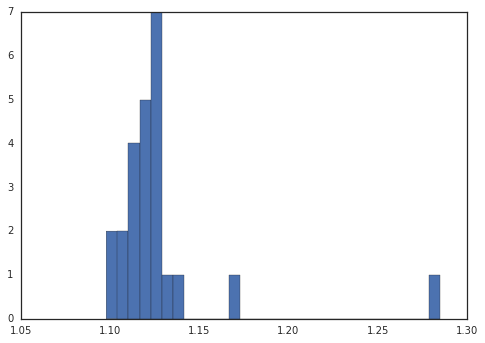

24


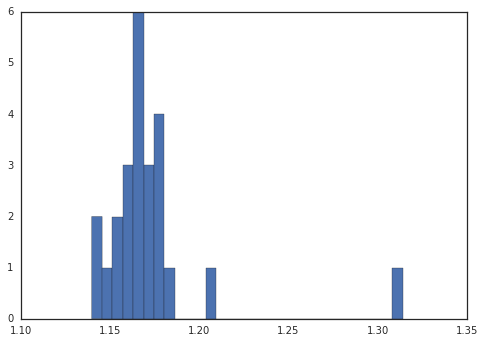

In [6]:
train_mean_per_seed = np.mean(indiv_train_losses,axis=1)
print(len(train_mean_per_seed))
plt.hist(train_mean_per_seed,bins=30)
plt.show()

test_mean_per_seed = np.mean(indiv_test_losses,axis=1)
print(len(test_mean_per_seed))
plt.hist(test_mean_per_seed,bins=30)
plt.show()

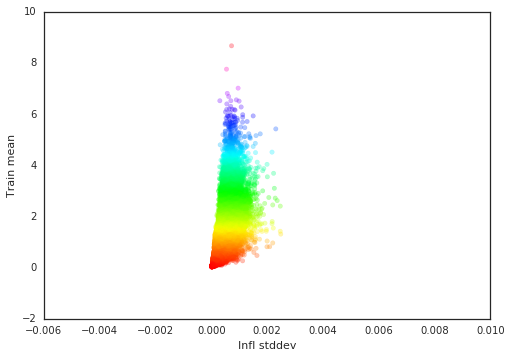

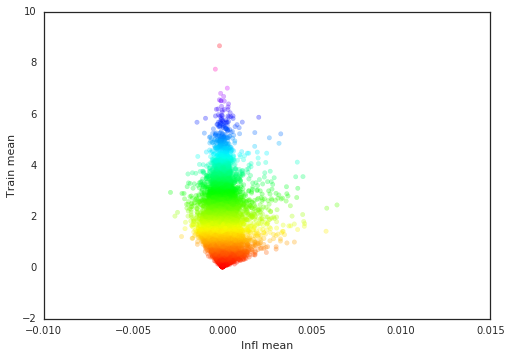

In [7]:
plt.scatter(infl_stddevs, train_means, alpha=0.3, color=plt.cm.hsv(normalize(train_means)))
plt.xlabel('Infl stddev')
plt.ylabel('Train mean')
plt.show()

plt.scatter(infl_means, train_means, alpha=0.3, color=plt.cm.hsv(normalize(train_means)))
plt.xlabel('Infl mean')
plt.ylabel('Train mean')
plt.show()

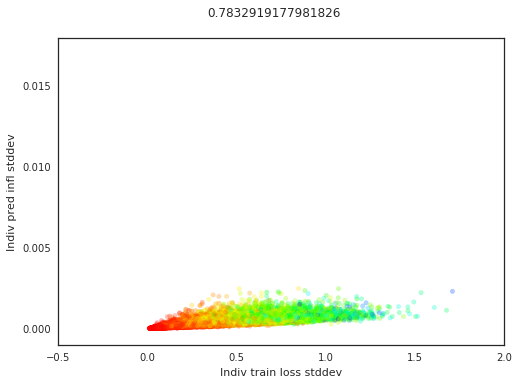

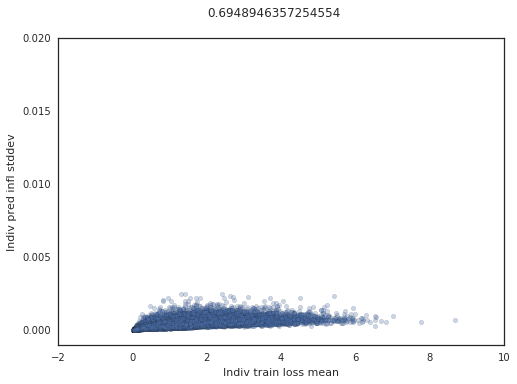

0.7878395
0.7789339


In [8]:
plt.suptitle(pearsonr(train_stddevs, infl_stddevs)[0])
plt.scatter(train_stddevs, infl_stddevs,alpha=0.3, color=plt.cm.hsv(normalize(train_means)))
plt.xlabel('Indiv train loss stddev')
plt.ylabel('Indiv pred infl stddev')
plt.ylim(-0.001,0.018)#06)
plt.show()

plt.suptitle(pearsonr(train_means, infl_stddevs)[0])
plt.scatter(train_means, infl_stddevs,alpha=0.3)
plt.xlabel('Indiv train loss mean')
plt.ylabel('Indiv pred infl stddev')
plt.ylim(-0.001,0.02)
plt.show()

print(pearsonr(train_means,train_stddevs)[0])
print(pearsonr(test_means,test_stddevs)[0])

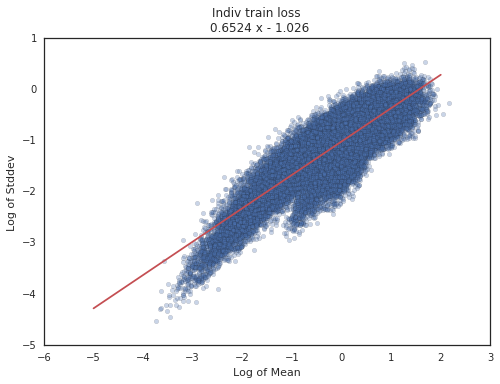

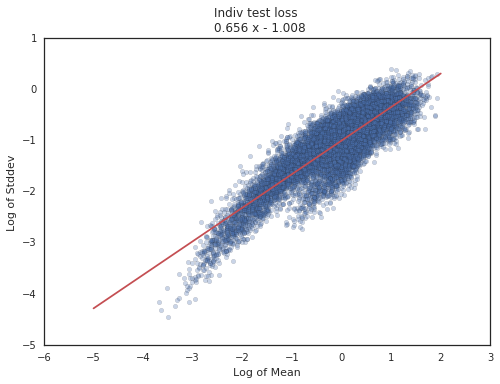

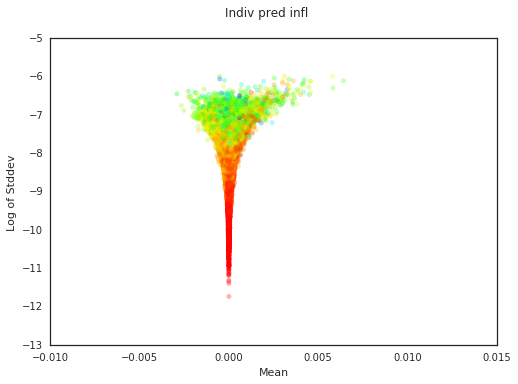

In [9]:
plt.scatter(np.log(train_means), np.log(train_stddevs),alpha=0.3)
plt.xlabel('Log of Mean')
plt.ylabel('Log of Stddev')
plt.plot(range(-5,3), np.poly1d(np.polyfit(np.log(train_means), np.log(train_stddevs), 1))(range(-5,3)),color='r')
plt.suptitle('Indiv train loss {}'.format(np.poly1d(np.polyfit(np.log(train_means), np.log(train_stddevs), 1))))
plt.show()

plt.scatter(np.log(test_means), np.log(test_stddevs),alpha=0.3)
plt.xlabel('Log of Mean')
plt.ylabel('Log of Stddev')
plt.plot(range(-5,3), np.poly1d(np.polyfit(np.log(test_means), np.log(test_stddevs), 1))(range(-5,3)),color='r')
plt.suptitle('Indiv test loss {}'.format(np.poly1d(np.polyfit(np.log(test_means), np.log(test_stddevs), 1))))
plt.show()

plt.suptitle('Indiv pred infl')
plt.scatter(infl_means, np.log(infl_stddevs),alpha=0.3, color=plt.cm.hsv(normalize(train_means)))
plt.xlabel('Mean')
plt.ylabel('Log of Stddev')
plt.show()

In [10]:
def plot_losses_over_time_seed(idx):
    plt.plot(losses_over_time[idx])
    plt.suptitle('Seed {}'.format(seeds[idx]))
    plt.xlabel('Thousands of steps')
    plt.ylabel('Test Loss')
    plt.show()

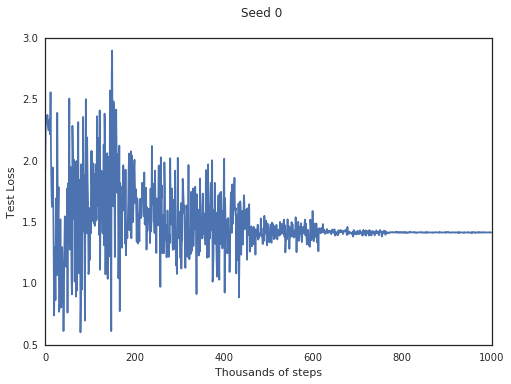

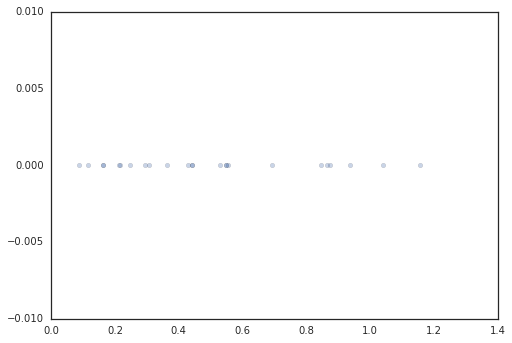

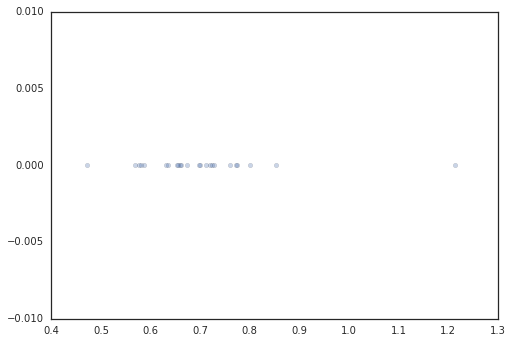

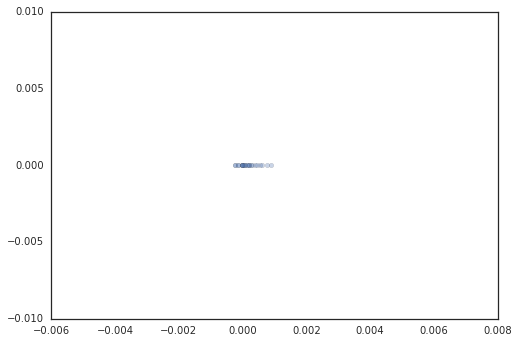

In [11]:
plot_losses_over_time_seed(0)

plt.scatter(indiv_train_losses[:,0],np.zeros(num_seeds),alpha=0.3)
plt.show()

plt.scatter(indiv_test_losses[:,0],np.zeros(num_seeds),alpha=0.3)
plt.show()

plt.scatter(indiv_pred_infls[:,0],np.zeros(num_seeds),alpha=0.3)
plt.show()

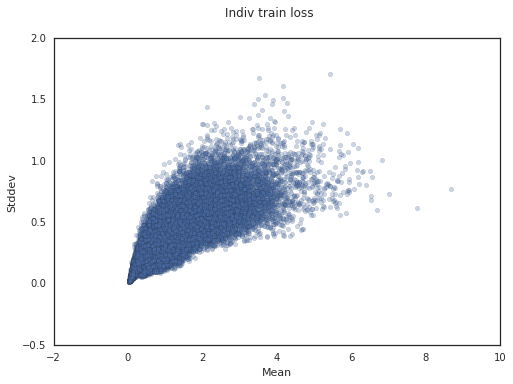

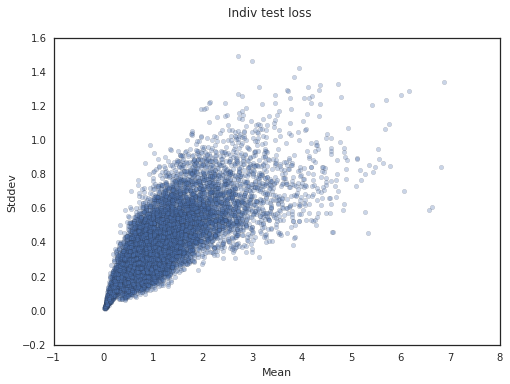

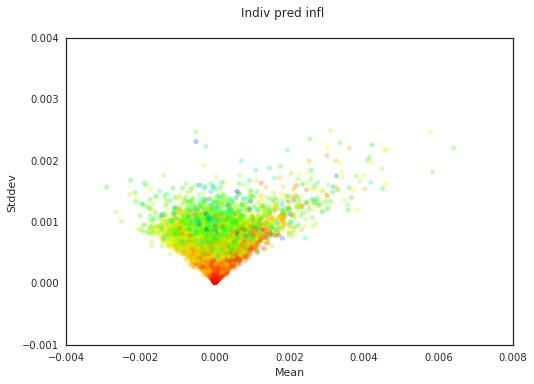

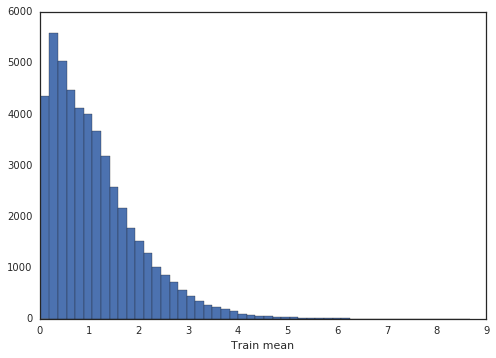

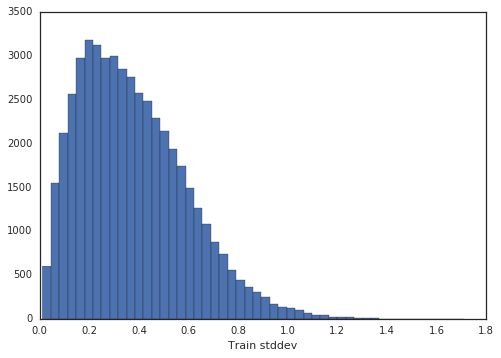

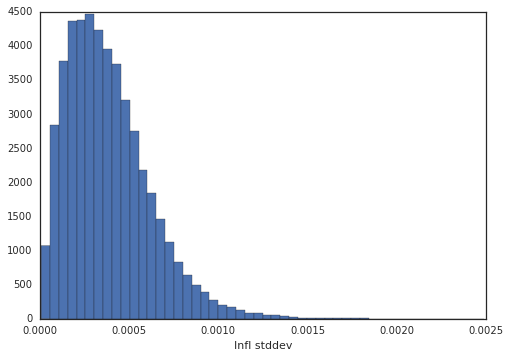

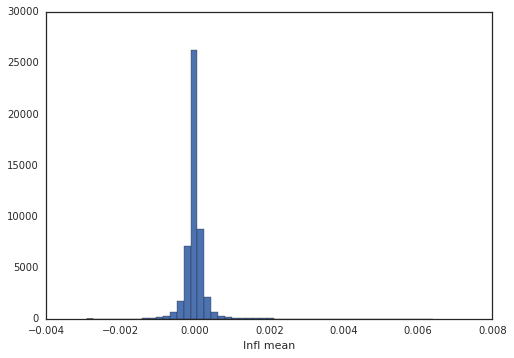

In [12]:
plt.suptitle('Indiv train loss')
plt.scatter(train_means, train_stddevs,alpha=0.3)
plt.xlabel('Mean')
plt.ylabel('Stddev')
plt.show()

plt.suptitle('Indiv test loss')
plt.scatter(test_means, test_stddevs,alpha=0.3)
plt.xlabel('Mean')
plt.ylabel('Stddev')
plt.show()

plt.suptitle('Indiv pred infl')
plt.scatter(infl_means, infl_stddevs,alpha=0.3, color=plt.cm.hsv(normalize(train_means)))
plt.xlabel('Mean')
plt.ylabel('Stddev')
plt.xlim(-0.004,0.008)
plt.ylim(-0.001,0.004)
plt.show()

plt.hist(train_means,bins=50)
plt.xlabel('Train mean')
plt.show()

plt.hist(train_stddevs,bins=50)
plt.xlabel('Train stddev')
plt.show()

plt.hist(infl_stddevs,bins=50)
plt.xlabel('Infl stddev')
plt.show()

plt.hist(infl_means,bins=50)
plt.xlabel('Infl mean')
plt.show()

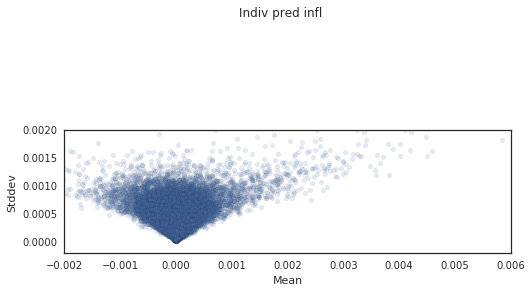

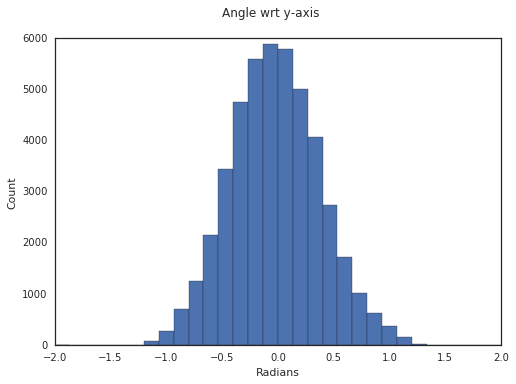

In [13]:
plt.suptitle('Indiv pred infl')
plt.scatter(infl_means, infl_stddevs,alpha=0.15)
plt.xlabel('Mean')
plt.ylabel('Stddev')
plt.axes().set_aspect('equal')
plt.xlim(-0.002,0.006)
plt.ylim(-0.0002,0.002)
plt.show()

indices = np.greater(infl_stddevs,[0.0001]*len(infl_stddevs))
infl_means = np.array(infl_means)
infl_stddevs = np.array(infl_stddevs)
plt.suptitle('Angle wrt y-axis')
plt.xlabel('Radians')
plt.ylabel('Count')
plt.hist(np.arctan(np.divide(infl_means[np.where(indices)[0]],infl_stddevs[np.where(indices)[0]])),bins=30,range=(-2,2))
plt.show()